In [ ]:
# necessary imports
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural networks
import torch.nn.functional as F # import functions like Relu
import torch.optim as optim # optimizer
print("Using torch", torch.__version__)

Using torch 2.3.0+cu121


In [ ]:
# Setting the seed
# replace list of student ids (here [34xxx, ...]) with last 5 digits of the student ids of your group members
group_studentids = [34670, 34772, 34674]
groupid = int(sum(group_studentids)/len(group_studentids))
torch.manual_seed(groupid)

#### Classification for CIFAR-100

##### Load the dataset from torchvision

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Set batch_size and number of workers
batch_size = 64
num_workers = 4

# Load train data
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Load test data
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Verify the data loaders
print("Number of training batches:", len(trainloader))
print("Number of testing batches:", len(testloader))
print(f'Number of classes: {len(trainset.classes)}')

100%|██████████| 169001437/169001437 [00:05<00:00, 29838513.70it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Number of training batches: 782
Number of testing batches: 157
Number of classes: 100


#### Convolutional Neural Network (CNN)

In [ ]:
# set model hyperparameters
d_in = 3 # rgb - 3 channels
d_out = 100
activation_fn = nn.ReLU()

In [ ]:
# DEFINE NEURAL NETWORK CLASS
class ConvNetDA520(nn.Module):
    def __init__(self):
      super(ConvNetDA520, self).__init__()
      # 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
      self.conv1 = nn.Conv2d(in_channels=d_in, out_channels=20, kernel_size=5, padding='valid') # 32x32 => 28x28

      # 2. A max pooling operation over a 2x2 area
      self.maxpool1 = nn.MaxPool2d(kernel_size=2) # 28x28 => 14x14

      # 3. A Relu
      self.act_fn = activation_fn

      # 4. A valid convolution with kernel size 5, 100 input channels and 20 output channels
      self.conv2 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding='valid') # 14x14 => 10x10

      # 5. A 2D Dropout layer
      self.drop = nn.Dropout2d(p=0.5)
      self.maxpool2 = nn.MaxPool2d(kernel_size=2) # 10x10 => 5x5

      # 6. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
      self.fc1 = nn.Linear(in_features=5*5*30, out_features=50)

      # 7. A fully connected layer mapping from 500 to 100 dimensions
      self.fc2 = nn.Linear(in_features=50, out_features=100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.act_fn(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.maxpool2(x)
        x = self.act_fn(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) #softmax + nll / crossentropy #düşünelim
        return x
# use different convolutional and pooling layer configurations

##### Create and Train CNN Model

In [ ]:
model = ConvNetDA520()

# Initialize model weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

model.apply(weights_init)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Main training routine
def train(epochs, model):
  losses_train = np.zeros((epochs))
  errors_train = np.zeros((epochs))
  losses_val = np.zeros((epochs))
  errors_val = np.zeros((epochs))
  accuracy_train = np.zeros((epochs))
  accuracy_val =np.zeros((epochs))
  for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()

    model.eval()
    train_correct = 0 #for accuracy
    train_loss = 0
    val_correct = 0 #for accuracy
    val_loss = 0

    with torch.no_grad():
      for data, target in trainloader:
        output = model(data)
        train_loss += loss_fn(output, target).item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

      for data, target in testloader:
        output = model(data)
        val_loss += loss_fn(output, target).item()
        _, predicted = torch.max(output, 1)
        val_correct += (predicted == target).sum().item()

    train_accuracy = 100. * train_correct / len(trainloader.dataset)
    val_accuracy = 100. * val_correct / len(testloader.dataset)

    errors_train[epoch] = 100 - train_accuracy
    errors_val[epoch] = 100 - val_accuracy
    losses_train[epoch] = train_loss
    losses_val[epoch] = val_loss
    accuracy_train[epoch] = train_accuracy
    accuracy_val[epoch] = val_accuracy

    print(f'Epoch {epoch:5d}, train loss {train_loss:.6f}, train accuracy {accuracy_train[epoch]:3.2f}, val loss {val_loss:.6f}, val error {errors_val[epoch]:3.2f}')

  return model, errors_train, errors_val, losses_train, losses_val, accuracy_train, accuracy_val


In [ ]:
# Train the model
epochs = 50

trained_model, errors_train, errors_val, losses_train, losses_val, accuracy_train, accuracy_val = train(epochs, model)

Epoch     0, train loss 3106.499215, train accuracy 10.65, val loss 627.170772, val error 89.59
Epoch     1, train loss 2896.995012, train accuracy 14.25, val loss 587.498171, val error 86.10
Epoch     2, train loss 2754.067101, train accuracy 17.55, val loss 562.538866, val error 83.47
Epoch     3, train loss 2682.284593, train accuracy 19.69, val loss 549.041087, val error 81.91
Epoch     4, train loss 2561.250432, train accuracy 21.94, val loss 526.668368, val error 79.71
Epoch     5, train loss 2519.549774, train accuracy 23.06, val loss 520.072831, val error 78.92
Epoch     6, train loss 2443.976754, train accuracy 25.78, val loss 506.739607, val error 76.67
Epoch     7, train loss 2331.531075, train accuracy 27.96, val loss 488.377648, val error 74.73
Epoch     8, train loss 2293.859428, train accuracy 28.97, val loss 482.132123, val error 74.08
Epoch     9, train loss 2246.237526, train accuracy 30.52, val loss 474.017062, val error 72.49
Epoch    10, train loss 2248.136276, tra

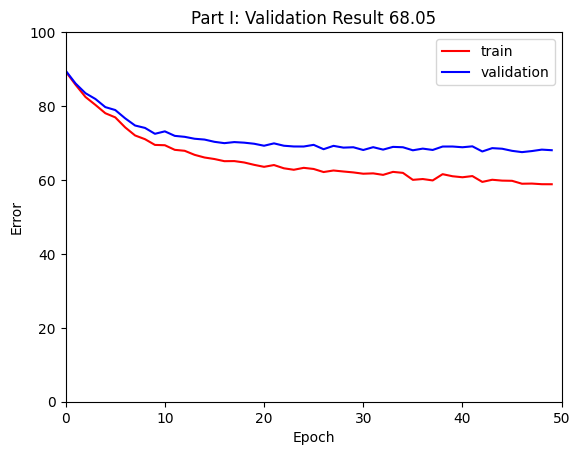

In [ ]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,epochs)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()

In [ ]:
# save best performing model to be deployed together with the hyperparameters
PATH = f"trained_model_cifar100_{groupid}"
torch.save(trained_model, PATH)

# Test Function

In [ ]:
# Run on test data
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  return test_loss, 100. * correct / len(testloader.dataset)

In [ ]:
test(trained_model)

# Test accuracy of our first developed model is 32%


Test set: Avg. loss: 0.0426, Accuracy: 3195/10000 (32%)



(0.04264784121513367, tensor(31.9500))

##### Experiment with Hyperparameters and Architectures

In [ ]:
## set model hyperparameters
d_in = 3 # rgb - 3 channels
d_out = 100

learning_rate = [0.01, 0.001]
batch_sizes = [64, 128]
optimizers = ['SGD', 'Adam']

# Creating optimizer function
def get_optimizer(model, optimizer_name, lr):
  if optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    return optimizer
  elif optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

In [ ]:
# Hyperparameters Search

best_accuracy = 0
best_train_loss = float('inf')
best_model = None
best_params = {}

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for i in batch_sizes:
  for optimizer_name in optimizers:
    for k in learning_rate:
      trainloader = torch.utils.data.DataLoader(trainset, batch_size=i, shuffle=True, num_workers=num_workers)
      testloader = torch.utils.data.DataLoader(testset, batch_size=i, shuffle=False, num_workers=num_workers)

      n_epoch = 50
      model = ConvNetDA520()
      model.apply(weights_init)  # Initialize model weights in each hyperparameter set

      optimizer = get_optimizer(model, optimizer_name, k)
      trained_model2, errors_train2, errors_val2, losses_train2, losses_val2, train_accuracy2, val_accuracy2 = train(n_epoch, model)

      final_error = errors_train2[-1]
      final_accuracy = train_accuracy2[-1]
      final_loss = losses_train2[-1]

      if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_train_loss = final_loss
        best_model = trained_model2
        best_params = {'batch_size': i, 'optimizer': optimizer_name, 'learning_rate': k}

      print(f"Batch Size: {i}, Optimizer: {optimizer_name}, Learning Rate: {k} -> Accuracy: {best_accuracy}, Loss: {best_train_loss}")

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("Best Train Loss:", best_train_loss)

# save best performing model to be deployed together with the hyperparameters
PATH = f"best_model_hyperparam_cifar100_{groupid}"
torch.save(best_model, PATH)

Epoch     0, train loss 3464.922852, train accuracy 4.06, val loss 695.475918, val error 96.16
Epoch     1, train loss 3331.320698, train accuracy 6.66, val loss 668.915283, val error 93.86
Epoch     2, train loss 3237.485664, train accuracy 9.42, val loss 650.735198, val error 90.78
Epoch     3, train loss 3153.571194, train accuracy 9.89, val loss 634.531567, val error 90.05
Epoch     4, train loss 2988.063787, train accuracy 12.30, val loss 603.359018, val error 87.66
Epoch     5, train loss 2898.661586, train accuracy 14.84, val loss 587.536778, val error 85.68
Epoch     6, train loss 2812.044463, train accuracy 16.58, val loss 572.297544, val error 84.22
Epoch     7, train loss 2743.023578, train accuracy 18.45, val loss 559.735398, val error 82.79
Epoch     8, train loss 2711.748390, train accuracy 18.91, val loss 554.017847, val error 81.89
Epoch     9, train loss 2621.665107, train accuracy 20.20, val loss 537.268184, val error 80.55
Epoch    10, train loss 2566.568774, train a

In [ ]:
hyperparameters = {
    'activation_fn': activation_fn,
    'learning_rate': 0.01,
    'n_epoch': 50,
    'optimizer': 'SGD',
    'batch_size': 64
}
import pickle
PATH_HYP = f"hyperparameters_cifar100_{groupid}"
with open(PATH_HYP, 'wb') as f:
    pickle.dump(hyperparameters, f)

In [ ]:
test(best_model)
# Best hyperparameter set is batch size: 64 - optimizer: SGD - learning_rate: 0.01
# Due to performance issues, we were not able to try more combinations.
# The best model with this hyperparameter set has a train accuracy of 42.48
# The best model with this hyperparameter set has a test accuracy of 34% as seen below


Test set: Avg. loss: 0.0211, Accuracy: 3368/10000 (34%)



(0.021108711981773377, tensor(33.6800))

In [ ]:
best_accuracy # The best model with this hyperparameter set has a train accuracy of 42.48

42.448

**While developing new architecture for convolutional neural network, we faced a problem where accuracy stayed the same in all epochs despite setting every step correct. So, we continued this part in another Colab file named "ClassNewArch_Second_Approach_DA520"**

##### Save the Final Model

In [ ]:
# We saved our final model, which is found in hyperparameter search, above. It is named "best_model_hyperparam_cifar100"